In [1]:
import pandas as pd
import numpy as np
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras


In [2]:
# ----------------------------
# 1) LOAD THE DATA
# ----------------------------
train_csv_path = "./symptom-disease-train-dataset.csv"
test_csv_path = "./symptom-disease-test-dataset.csv"
mapping_json_path = "./mapping.json"

# Load the CSV files; they have columns "text" and "label"
df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)

# ----------------------------
# 2) RE-MAP LABELS TO CONTIGUOUS INDICES
# ----------------------------
# Get the unique original labels (they might be arbitrary numbers like 1047, 207, etc.)
unique_labels = sorted(df_train["label"].unique())

# Create mapping dictionaries: original -> new, and new -> original.
label_to_index = {label: i for i, label in enumerate(unique_labels)}
index_to_label = {i: label for label, i in label_to_index.items()}

# Map the labels in the dataframes
df_train["new_label"] = df_train["label"].map(label_to_index)
df_test["new_label"] = df_test["label"].map(label_to_index)

# For training and evaluation, use the new contiguous labels
X_train_text = df_train["text"]
y_train = df_train["new_label"]

X_test_text = df_test["text"]
y_test = df_test["new_label"]

In [3]:
# ----------------------------
# 3) LOAD THE MAPPING & SET UP REVERSE MAPPING
# ----------------------------
# mapping.json maps disease names to original label codes, e.g., {"(Vertigo) Paroymsal  Positional Vertigo": 1047, ...}
with open(mapping_json_path, 'r') as f:
    disease_mapping_dict = json.load(f)

# Create a reverse mapping: from original label code to disease name.
reverse_mapping = {value: key for key, value in disease_mapping_dict.items()}

In [4]:
# ----------------------------
# 4) TEXT PREPROCESSING WITH TEXT VECTORIZATION
# ----------------------------
max_features = 20000  # Maximum number of tokens to consider
vectorizer = keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='tf_idf'
)

# Adapt the vectorizer on the training text
vectorizer.adapt(X_train_text)

# Transform the training and test text into numeric vectors
X_train_vectorized = vectorizer(X_train_text)
X_test_vectorized = vectorizer(X_test_text)

In [5]:
# ----------------------------
# 5) BUILD THE DEEP LEARNING MODEL
# ----------------------------
num_diseases = len(unique_labels)  # Use the number of contiguous classes

model = keras.Sequential([
    keras.layers.Input(shape=(X_train_vectorized.shape[1],)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(num_diseases, activation='softmax')
])


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     2,108,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 866)            │        56,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,207,906 (8.42 MB)

 Trainable params: 2,207,010 (8.42 MB)

 Non-trainable params: 896 (3.50 KB)

In [6]:
# ----------------------------
# 6) TRAIN THE MODEL
# ----------------------------
history = model.fit(
    X_train_vectorized, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_vectorized, y_test)
)


Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0597 - loss: 6.4931 - val_accuracy: 0.0646 - val_loss: 5.7165
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3477 - loss: 4.1460 - val_accuracy: 0.4975 - val_loss: 3.2305
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5537 - loss: 2.4371 - val_accuracy: 0.6608 - val_loss: 2.2383
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6202 - loss: 2.0396 - val_accuracy: 0.7530 - val_loss: 1.7398
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6938 - loss: 1.6686 - val_accuracy: 0.7956 - val_loss: 1.5004
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7275 - loss: 1.5415 - val_accuracy: 0.8098 - val_loss: 1.3888
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7494 - loss: 1.3950 - val_accuracy: 0.8141 - val_loss: 1.4029
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7825 - loss: 1.2656 - val_accuracy: 0.

In [7]:
# ----------------------------
# 7) EVALUATE THE MODEL
# ----------------------------
test_loss, test_accuracy = model.evaluate(X_test_vectorized, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.5631
Test Accuracy: 0.8318


In [8]:
# ----------------------------
# 9) EXAMPLE: MAKING A PREDICTION ON NEW DATA
# ----------------------------
new_sample = ["I have been having high fever, cough and body aches"]
new_sample_vectorized = vectorizer(new_sample)
predictions = model.predict(new_sample_vectorized)
predicted_new_label = int(np.argmax(predictions[0]))

# Convert the contiguous label back to the original label code
predicted_original_label = index_to_label[predicted_new_label]

# Use the reverse mapping from original label code to disease name
predicted_disease = reverse_mapping.get(predicted_original_label, "Unknown")
print("Predicted Disease:", predicted_disease)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Disease: Bronchial Asthma


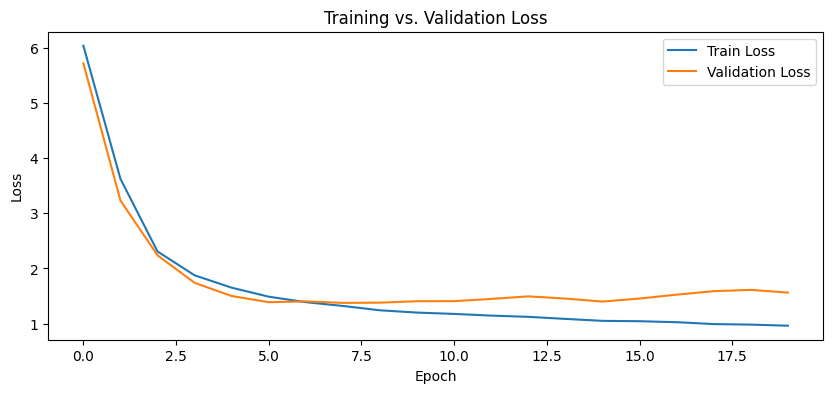

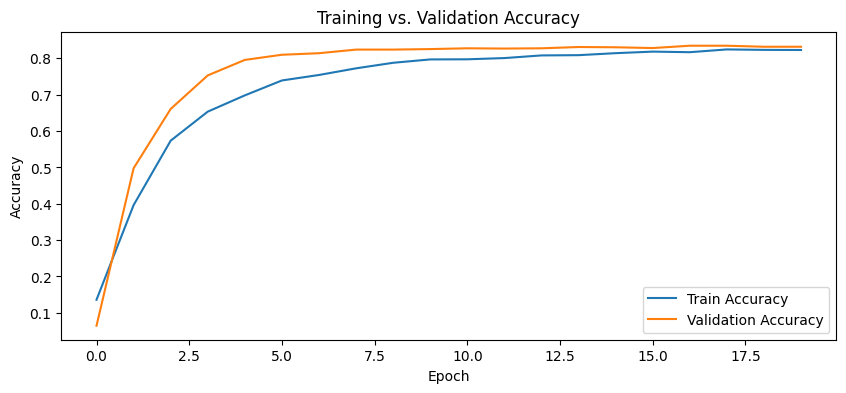

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ----------------------------
# Plot Training and Validation Loss
# ----------------------------
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ----------------------------
# Plot Training and Validation Accuracy
# ----------------------------
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
# ----------------------------
# 7) SAVE THE TRAINED MODEL
# ----------------------------
model_save_path = "./trained_model1.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./trained_model1.h5
